# XGBoost Classifier Model

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
# Load the data
df = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Fake-Job-Posts/Data/Cleaned_Processed_Data.csv')


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Separate numericals and categoricals
numerical = ['telecommuting','has_company_logo','has_questions','description_length']
categorical = ['dominant_topic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(), categorical)],
         remainder= 'passthrough')

# Build pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier())
])

# Split the data
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
xgb = pipeline.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.95      0.68      0.79       181

    accuracy                           0.98      3576
   macro avg       0.96      0.84      0.89      3576
weighted avg       0.98      0.98      0.98      3576

0.9818232662192393


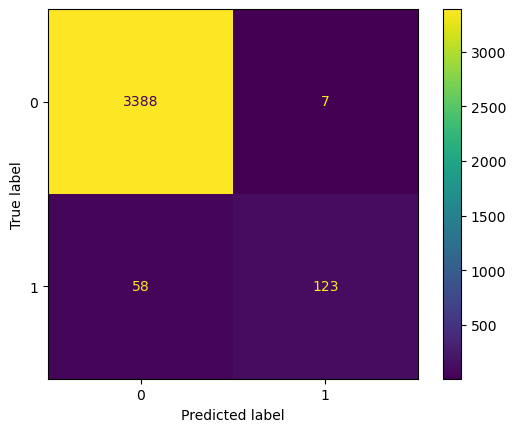

In [7]:

# Evaluate the model
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)

Looks like the model is overfitting on the majority class. Need to do some tuning

# GridSearchCV Tuning

In [11]:
param_test1 = {
    "classifier__max_depth": range(3,10,2),
    "classifier__min_child_weight": range(1,6,2),
    "classifier__n_estimators": range(100,500,1000),
    "classifier__learning_rate": [.001,.01,.1]
}

gsearch1 = GridSearchCV(
    estimator=pipeline,  # Use the full pipeline here
    param_grid=param_test1,
    n_jobs=2,
    cv=3
)

gsearch1.fit(X_train, y_train)

KeyboardInterrupt: 